# Pytorch dataloader

在一般的 CNN 任務中，影像維度為 $(bs,c,h,w)$，其中

- bs: batch size
- c: channel
- h: height
- w: width

注意，在一個 batch 中影像要相同大小，不同 batch 中，影像大小不一定一樣，如現在最熱門的網路架構，都會在 backbone 的最後一層加上 global pooling 和 adaptive pooling，這使我們不同 batch 中的影像不需要相同長寬

## 讀取資料

怎麼讓網路批次讀取影像資料呢? 我們可以透過 pytorch dataloader 來達成，pytorch dataloader 包含三個部分
- sampler: 抽樣方式
- dataset: 對影像的處理方法
- collate_fn: 對一個批次進行整合

具體流程如下:

sampler --> indices --> dataset --> collate_fn

### 範例代碼

以下我們載入 torchvision 的 fashion MNIST 為例

(https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [ ]:
from torchvision import datasets

In [ ]:
from torchvision import transforms

In [ ]:
#collapse-output
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



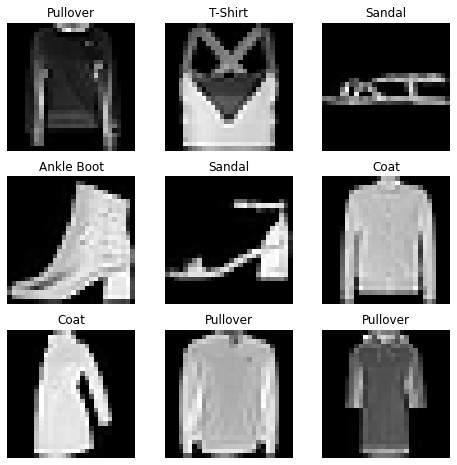

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Dataset

pytroch Dataset 是用來處理資料處理過程的物件，我們必須自訂資料集物件並繼承 Dataset，我們的自訂義類別需要包含三個部分

- ```__init__(self,...):``` 初始化設定，我們通常會把影像路徑放在這裡，並且設定一些參數
- ```__getitem__(self, idx):``` 會傳入 sampler 抽出的 index，我們需要利用 index 取得影像，通常我們也會把數據增強方法寫在這一塊內
- ```__len__(self):``` 回傳總共數據數量

具體範例如下

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### Dataloader

dataloader 的過程可以簡化成以下流程

```python
for indices in batch_sampler:
    yield collate_fn([dataset[i] for i in indices])
```

視覺化請見 [pytorch dataloader](https://twitter.com/i/status/1363494433715552259)

#### 基本用法

In [ ]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [ ]:
for (img, target) in train_dataloader:
    print(f"(bs, channels, w, h): {img.numpy().shape}")
    break

(bs, channels, w, h): (64, 1, 28, 28)


#### Sampler

Sampler 是一個帶有 ```__len__``` 的 iterator，換句話說，如果需要自定義 Sampler 需要包含三個部分

- ```__init__:``` 初始化設定
- ```__iter__:``` 每次 iteration 中抽取 indices 的方法，回傳一個包含 indices 的 list，通常用 yield 方法
- ```__len__:``` 數據長度

In [ ]:
class Demo(torch.utils.data.Dataset):

    def __init__(self):
        pass

    def __getitem__(self, x):
        return torch.rand(3,128,128)

    def __len__(self):
        return 1000

In [ ]:
from torch.utils.data import BatchSampler, SequentialSampler, WeightedRandomSampler

In [ ]:
train_dataloader = DataLoader(Demo(), batch_size=64, sampler=BatchSampler(
        SequentialSampler(Demo()), batch_size=1, drop_last=False
    ), drop_last=True)

In [ ]:
#collapse-output
for img in train_dataloader:
    print(f"(bs, channels, w, h): {img.numpy().shape}")

(bs, channels, w, h): (64, 3, 128, 128)
(bs, channels, w, h): (64, 3, 128, 128)
(bs, channels, w, h): (64, 3, 128, 128)
(bs, channels, w, h): (64, 3, 128, 128)
(bs, channels, w, h): (64, 3, 128, 128)
(bs, channels, w, h): (64, 3, 128, 128)
(bs, channels, w, h): (64, 3, 128, 128)
(bs, channels, w, h): (64, 3, 128, 128)
(bs, channels, w, h): (64, 3, 128, 128)
(bs, channels, w, h): (64, 3, 128, 128)
(bs, channels, w, h): (64, 3, 128, 128)
(bs, channels, w, h): (64, 3, 128, 128)
(bs, channels, w, h): (64, 3, 128, 128)
(bs, channels, w, h): (64, 3, 128, 128)
(bs, channels, w, h): (64, 3, 128, 128)


#### collate_fn

collate_fn 主要用來對一整個 batch 的資料做整合，做常見的用法是當一個 batch 資料大小不一致時可以使用 collate_fn 對 batch 中的資料做大小調整，詳細代碼請如下

In [ ]:
class Demo(torch.utils.data.Dataset):

    def __init__(self):
        pass

    def __getitem__(self, x):
        h = torch.randint(123,130,(1,))
        w = torch.randint(123,130,(1,))
        return torch.rand(3,w,h), torch.rand(3,w,h)

    def __len__(self):
        return 1000

In [ ]:
def collate_fn(batch):
    images, targets = list(zip(*batch))
    batched_imgs = cat_list(images, fill_value=0)
    batched_targets = cat_list(targets, fill_value=255)
    return batched_imgs, batched_targets

def cat_list(images, fill_value=0):

    max_size = tuple(max(s) for s in zip(*[img.shape for img in images]))
    batch_shape = (len(images),) + max_size
    batched_imgs = images[0].new(*batch_shape).fill_(fill_value)
    for img, pad_img in zip(images, batched_imgs):
        pad_img[..., :img.shape[-2], :img.shape[-1]].copy_(img)
        
    return batched_imgs

In [ ]:
train_dataloader = DataLoader(Demo(), batch_size=64, collate_fn=collate_fn)

In [ ]:
for (img, target) in train_dataloader:
    print(f"(bs, channels, w, h): {img.numpy().shape}")
    break

(bs, channels, w, h): (64, 3, 129, 129)
